In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.signal as sg
import scipy.ndimage as img
import seaborn as sns

from functions.latex import set_size, produce_table
from skimage import measure

#import cmocean



datadir = "../data/"
figdir = "../figures/"

g = 9.81
R = 6371e3
omega = 7.29e-5

In [3]:
def get_region_coords(region_name="arctic_ocean", xy=False):
    region_dict = {
        "arctic_ocean": {False: [-180, 180, 60, 90], True: [65, 185, 0, 215]},
        "canada_basin": {False: [-180, -95, 70, 85], True: [70, 130, 135, 205]},
        "amerasian_basin": {False: [], True: [70, 160, 120, 205]},
        "eurasian_basin": {False: [-180, 180, 78, 90], True: [110, 180, 80, 170]},
        "makarov_basin": {False: [-180, 180, 78, 90], True: [110, 155, 120, 190]},
        "greenland_basin": {False: [-15, 15, 72, 80], True: [110, 145, 50, 85]},
        "lofoten_basin": {False: [-5, 13.5, 68, 73], True: [125, 145, 30, 55]},
        "norwegian_basin": {False: [-8, 3, 63, 71], True: [115, 135, 15, 45]},
        "norwegian_seas": {False: [-15, 15, 62, 73], True: [115, 155, 10, 55]},
        "nordic_seas": {False: [-15, 15, 62, 73], True: [75, 175, 0, 90]},
    }
    
    if region_name not in region_dict:
        raise ValueError("Undefined region, please check spelling.")
    
    return region_dict[region_name][xy]

region_contours = {
    #"arctic_ocean" : [800, 1000, 1250, 1500, 1800, 2000, 2300],
    "arctic_ocean" : [1000, 1200, 1400, 1600, 1800, 2000, 2200],
    #"canada_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3750],
    "canada_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3800],
    #"makarov_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3800],
    "makarov_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3800],
    #"eurasian_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200],
    "eurasian_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200],
    #"greenland_basin" : [2550, 2625, 2800, 3000, 3200, 3400, 3600],
    "greenland_basin" : [2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700],
    #"norwegian_seas" : [2500, 2700, 2900, 3050],
    "norwegian_seas" : [2700, 2800, 2900, 3000, 3100, 3200],
    #"lofoten_basin" : [3150, 3200],
    "lofoten_basin" : [3350, 3400, 3450],
    #"norwegian_basin" : [3150, 3275, 3450, 3600]
    "norwegian_basin" : [3350, 3400, 3450, 3500, 3550, 3600, 3650, 3700, 3750, 3800, 3850, 3900]
}

In [4]:
def compute_along_contour_vector(ds, vector, contour, normalize=False):
    norm = np.sqrt(ds_interp[vector[0]]**2 + ds_interp[vector[1]]**2)
    uc = ds_interp[vector[0]]*contour.tx + ds_interp[vector[1]]*contour.ty + (-ds_interp[vector[0]]*contour.ty + ds_interp[vector[1]]*contour.tx)*1j
    if normalize:
        uc /= norm
    return uc

In [5]:
mdt_list = ["dtu", "cnes"]
hydrography_list = ["woa", "mimoc"]
vector = ["us", "vs"]

ds_dict = {}
for mdt in mdt_list:
    for hydrography in hydrography_list:
        ds = xr.open_dataset(datadir + f"velocities_{mdt}_{hydrography}_ease.nc")
        ds_dict[f"{mdt}_{hydrography}"] =  ds

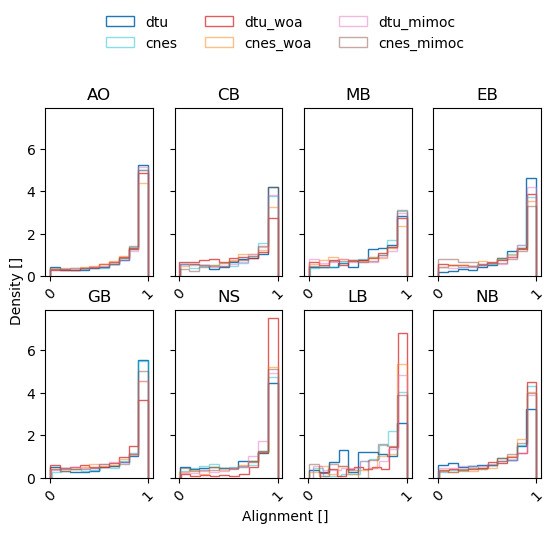

In [28]:
fig, axes = plt.subplots(nrows=2,
                       ncols=4,
                       sharey=True,
                       #figsize=set_size(width="beamer", subplots=(4, 3))
                      )

ds_list = ["dtu_woa", "cnes_woa", "dtu_woa", "cnes_woa", "dtu_mimoc", "cnes_mimoc"]
vectors = [["us", "vs"], ["us", "vs"], ["ub", "vb"], ["ub", "vb"], ["ub", "vb"], ["ub", "vb"]]
colors = ["tab:blue", "tab:cyan", "tab:red", "tab:orange", "tab:pink", "tab:brown"]
markers = [".", "*", "s", "p", "D", "X"]
alphas = [1, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5]

for ds_name, vector, color, marker, alpha in zip(ds_list, vectors, colors, markers, alphas):
    for ax, region_name in zip(axes.flatten(), region_contours):
        region = get_region_coords(region_name, xy=True)
        contour_depths = region_contours[region_name]
        ds = ds_dict[ds_name]
        ds_sel = ds.sel(x=slice(region[0], region[1]),
                        y=slice(region[2], region[3]))
        velocities = []
        circulations = []
        for contour_depth in contour_depths:
            contour = xr.open_dataset(datadir + region_name + "/contour_eff_" + str(contour_depth) + ".nc")
            ds_interp = ds_sel.interp(x=contour.x, y=contour.y)
            ds_interp["uc"] = np.abs(compute_along_contour_vector(ds, vector=vector, contour=contour, normalize=True).real)
            circ = (ds_interp.uc.real*contour.distance).sum("point")/contour.distance.sum()
            circulations.append(circ.values)
            velocities += list(ds_interp["uc"].values)
        ax.hist(velocities,
                color=color,
                density=True,
                histtype="step",
                alpha=alpha,
                #stacked=True
               )
        ax.set_title((region_name.split('_', 1)[0][0] + region_name.split('_', 1)[1][0]).upper())
        ax.tick_params(axis="x", labelrotation=45)
fig.legend(["dtu", "cnes"] + [ds_name for ds_name in ds_list[2:]],
           loc="upper center",
           ncol=3,
           frameon=False,
           bbox_to_anchor=(0.5, 1.1)
          )
#fig.subplots_adjust(hspace=0.75, wspace=0.25)
fig.text(0.5, 0.02, "Alignment []",
         ha='center'
        )
fig.text(0.07, 0.5, r"Density []",
         va='center',
         rotation='vertical'
        )
fig.savefig(figdir + "alignment_histograms.png", dpi=300, bbox_inches="tight")